## Overview of architecture



## Running the algorithms

Main concepts:

* We work with _temporal variables_: we are often interested not only in the current value of the variable, but also its historical values. Such temporal variables are called _slots_ represented by the class `kaia.bro.core.Slot`. 
* The slots  for settings, sensor measurements, requested actions and intermediate variables are combined in the _space_ `kaia.bro.core.ISpace`. 
* The space is a "software bus" for different _units_ (callables or `kaia.bro.core.IUnit`), the units modify the `current_value` of some slots (meaning the value that is _computed_ at the time of the algorithm run), using `last_value` (meaning the value from the last algorithm's run), historical values and `current_value` of other slots.
* The space and the set of units form a `BroAlgorithm`.

We will define a simple algorithm that:
* Monitors a "sensor"
* If the value is greater than the `high_value`, the "device" turns on.
* If the value is lower than the `low_value`, the "devide" turns off.
* The device does not change state oftener than once per hour.

First, we need to develop a state. It has to be done in a very specific way:

In [1]:
from dataclasses import dataclass
from datetime import datetime
from kaia.bro.core import ISpace, Slot

@dataclass(frozen=True)
class ControlSpace(ISpace):
    timestamp: Slot[datetime] = Slot.field()
    measurement: Slot[float] = Slot.field()
    high_value: Slot[float] = Slot.field()
    low_value: Slot[float] = Slot.field()
    state: Slot[bool] = Slot.field()
    debug: Slot[str] = Slot.field()

These fields will be controlled in the following way:

* `timestamp* is just a time when the algorithm is executed. It will be controlled with `kaia.bro.amenities.Timer`
* `high_value` and `low_value` are settings. They will be controlled with `SettingsReader`
* `state` will be controlled by algorithm we design
* `measurement` should be controlled by a unit that reads sensor and sets the value to it. Since it's a demo, it will be instead computed by a mock algorithm. 

Let's define mock algorithm and control algorithm.

In [2]:
def get_state_duration(space: ControlSpace):
    last_change = (space
                   .history(space.timestamp, space.state)
                   .where(lambda z: z.state != space.state.last_value)
                   .select(lambda z: z.timestamp)
                   .first_or_default()
                  )
    if last_change is None:
        return None
    return (space.timestamp.last_value - last_change).total_seconds()/3600
    
def control(space: ControlSpace):
    target_state = None
    if space.measurement.current_value > space.high_value.current_value: 
        target_state = True
    if space.measurement.current_value < space.low_value.current_value:
        target_state = False
        
    space.debug.current_value = f'target: {target_state}. '
        
    if space.state.history.count()==0:
        space.state.current_value = target_state if target_state is not None else False
        space.debug.current_value += 'First time'
        return
    
    if target_state is None:
        space.state.current_value = space.state.last_value
        space.debug.current_value += 'No change request'
        return 
    
    delta = get_state_duration(space)
    space.debug.current_value += f'Timedelta {delta}'
    if delta is None or delta > 1:
        space.state.current_value = target_state
    else:
        space.state.current_value = space.state.last_value

            
class Mock:
    def __init__(self, measurement_change_per_minute):
        self.measurement_change_per_minute = measurement_change_per_minute
        
    def __call__(self, space: ControlSpace):
        if space.measurement.last_value is None:
            space.measurement.current_value = 50
            return
        time_delta = (space.timestamp.current_value - space.timestamp.last_value).total_seconds()/60
        value_delta = self.measurement_change_per_minute * time_delta
        if space.state.last_value:
            value_delta = -value_delta
        space.measurement.current_value = space.measurement.last_value + value_delta       

`get_state_duration` uses `space.history` method that zips several slots and yields their values as objects. The returning value of this method, as well as the method `Slot.history` is the `Queryable` from `yo_fluq_ds`, an object that decorates an iterable and adds C#-LINQ-style methods to query it. If you don't want to use LINQ methods, you can work with this object as with a simple iterable. 

Note that all historical methods return records/values in a reversed order, so the first value is the most recent. 


## Testing the algorithm with Unit tests

It is absolutely crucial to test you smart home solution if you don't want to wakeup in a ice-cold room one night. All the algorithms you develop must be stateless: it's implied by the architecture, it makes easy to restart the system. Also it's easier to test this way, because the behaviour of the system only depends on the data in the space.

To prepare the data in the space for the test, use:

In [3]:
space = Space()
space.setup_for_test(
    timestamp = [None],
    measurement = [None]
)

You may not specify all the slots, only those you need in your test. All the slots have to have the same amount of values, which also should be greater than zero. First 1..N-1 values are the historical values in the natural order, the last is the current value. 

Now, you can test an algorithm:

In [4]:
mock = Mock(0.1)
mock(space)
assert 50 == space.measurement.current_value

Less trivial test:

In [5]:
from datetime import datetime

space = Space()
space.setup_for_test(
    timestamp = [datetime(2022, 1, 1, 12, 0), datetime(2022,1,1,12, 2)],
    measurement = [50, None],
    state = [True, None]
)


mock = Mock(0.1)
mock(space)
assert space.measurement.current_value == 49.8

Unit tests are not the only one way to test you smart home solution, more of this will come. 

## Running and testing the algorithm

In [6]:
from kaia.bro.core import BroAlgorithm
from kaia.bro.amenities import SettingsReader, SettingsHandler, Timer

def create_algorithm(measurement_change_per_minute):
    space = Space()
    algorithm = BroAlgorithm(
        space,
        [
            SettingsReader(),
            SettingsHandler(space.high_value, value=80),
            SettingsHandler(space.low_value, value=50),
            Timer(space.timestamp, mock_time_delta_in_seconds=10),
            Mock(measurement_change_per_minute),
            control
        ],
    )
    return algorithm

Here: 
* `SettingsReader` reads settings from the communication unit. 
* `SettingsHandler` manages the values read by `SettingsReader` in a natural way: if the value was read, set it as a settings value; if it wasn't, keep the value from the previous iteration; if this is a first iteration, use default `value`.
* `Timer` is a timer. We will use it in a test mode, so the `Timer` is going to increment timestamp by `10` seconds, regardless of the actual time.
* `Mock` and `control` are the functions defined earlier.

Now we can run this algorithm:

<Axes: xlabel='timestamp'>

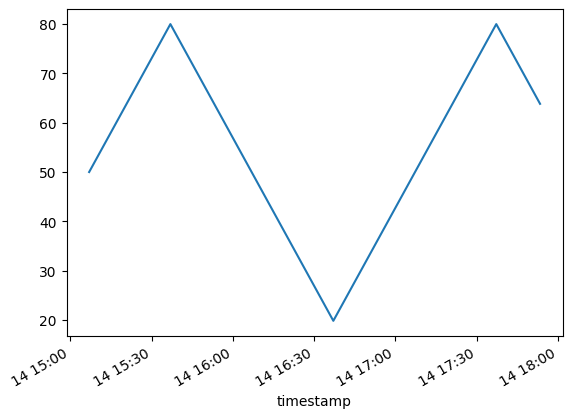

In [15]:
from kaia.infra.comm import FakeMessenger, FakeStorage

storage = FakeStorage()
messenger = FakeMessenger()
algorithm = create_algorithm(1)
for i in range(1000):
    algorithm.iterate(storage, messenger)
    
df = algorithm.space.as_data_frame()
df.set_index('timestamp').measurement.plot()

We see the system is "overdried" to the value less than 50. Let's check why it's the case:

In [17]:
df.loc[df.measurement<50].head(5)

,timestamp,measurement,high_value,low_value,state,debug
361,2023-07-14 16:07:03.650065,49.833333,80,50,True,target: False. Timedelta 0.5027777777777778
362,2023-07-14 16:07:13.650065,49.666667,80,50,True,target: False. Timedelta 0.5055555555555555
363,2023-07-14 16:07:23.650065,49.500000,80,50,True,target: False. Timedelta 0.5083333333333333
364,2023-07-14 16:07:33.650065,49.333333,80,50,True,target: False. Timedelta 0.5111111111111111
365,2023-07-14 16:07:43.650065,49.166667,80,50,True,target: False. Timedelta 0.5138888888888888


The `debug` field helps us to understand that actually the algorithm was aware of the need to stop, but the rule limiting the frequency of the state's change prevented it. Let's try to run with a different parameter:

<Axes: xlabel='timestamp'>

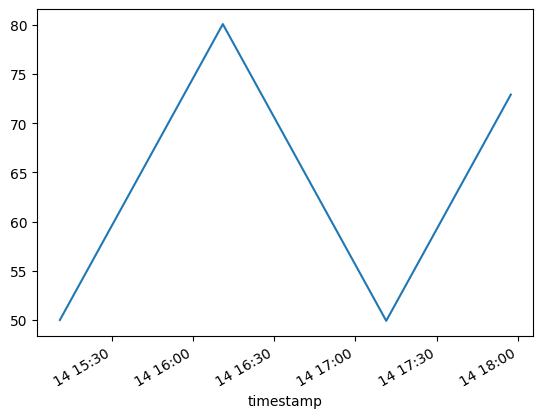

In [18]:
storage = FakeStorage()
messenger = FakeMessenger()
algorithm = create_algorithm(0.5)
for i in range(1000):
    algorithm.iterate(storage, messenger)
    
df = algorithm.space.as_data_frame()
df.set_index('timestamp').measurement.plot()

Here everything is perfect.